In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = '/content/drive/MyDrive/IoT project/iot23_combined.csv'
df = pd.read_csv(data_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446644 entries, 0 to 1446643
Data columns (total 26 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1446644 non-null  int64  
 1   duration           1446644 non-null  float64
 2   orig_bytes         1446644 non-null  int64  
 3   resp_bytes         1446644 non-null  int64  
 4   missed_bytes       1446644 non-null  float64
 5   orig_pkts          1446644 non-null  float64
 6   orig_ip_bytes      1446644 non-null  float64
 7   resp_pkts          1446644 non-null  float64
 8   resp_ip_bytes      1446644 non-null  float64
 9   label              1446644 non-null  object 
 10  proto_icmp         1446644 non-null  int64  
 11  proto_tcp          1446644 non-null  int64  
 12  proto_udp          1446644 non-null  int64  
 13  conn_state_OTH     1446644 non-null  int64  
 14  conn_state_REJ     1446644 non-null  int64  
 15  conn_state_RSTO    1446644 non-n

In [6]:
clear_df = df[df['label'].isin(['Attack', 'Benign'])].drop(['Unnamed: 0'], axis=1)
clear_df.shape

(203674, 25)

In [7]:
target = clear_df['label']
target.value_counts()

Benign    199758
Attack      3916
Name: label, dtype: int64

In [8]:
sample_3000 = clear_df.sample(n=3000)
sample_10000 = clear_df.sample(n=10000)
sample_15000 = clear_df.sample(n=15000)
sample_30000 = clear_df.sample(n=30000)
sample_150000 = clear_df.sample(n=150000)

In [9]:
X = clear_df.drop(['label'], axis=1)

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
low_space = pca.fit_transform(X)
low_space_table = pd.DataFrame(low_space, columns=['e1', 'e2'])
low_space_table['target'] = clear_df['label'].values
low_space_table.head(1)

,e1,e2,target
0,-2726.16852,-2243.361977,Benign


In [11]:
low_space_table['target'].value_counts()

Benign    199758
Attack      3916
Name: target, dtype: int64

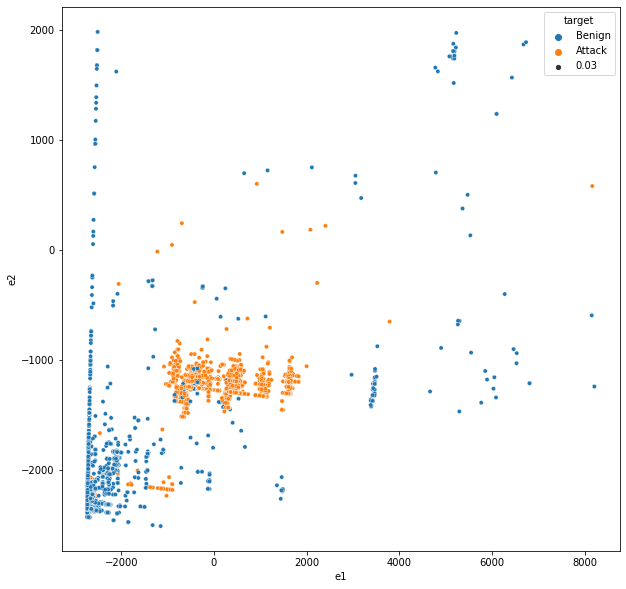

In [12]:
plt.figure(figsize=(10,10))
good_table = low_space_table[low_space_table['e1'] < 10000][low_space_table[low_space_table['e1'] < 10000]['e2']<2000]
sns.scatterplot(data=good_table,x='e1', y='e2', hue='target', size=0.03)

In [13]:
sample_from_good_table = good_table.sample(n=30000)

In [14]:
sample_from_good_table

,e1,e2,target
190141,-2733.467461,-2383.048253,Benign
80032,-2732.425207,-2363.102849,Benign
160823,-2726.168519,-2243.361976,Benign
21260,-2733.467461,-2383.048253,Benign
155712,-2732.425207,-2363.102849,Benign
...,...,...,...
160373,-2732.425207,-2363.102849,Benign
184827,-2733.467461,-2383.048253,Benign
124807,-2732.425207,-2363.102849,Benign
76682,-2726.168519,-2243.361976,Benign


In [15]:
X_small_sample = sample_from_good_table.drop(['target'], axis=1).values

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler_data = MinMaxScaler().fit_transform(X_small_sample)

In [17]:
scaler_data

array([[0.00023741, 0.01633398],
       [0.00035603, 0.02097746],
       [0.00106808, 0.04885428],
       ...,
       [0.00035603, 0.02097746],
       [0.00106808, 0.04885428],
       [0.00023741, 0.01633398]])

In [18]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.02).fit(scaler_data)

In [19]:
np.unique(model.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [20]:
sample_from_good_table['dbscan_lables'] = model.labels_

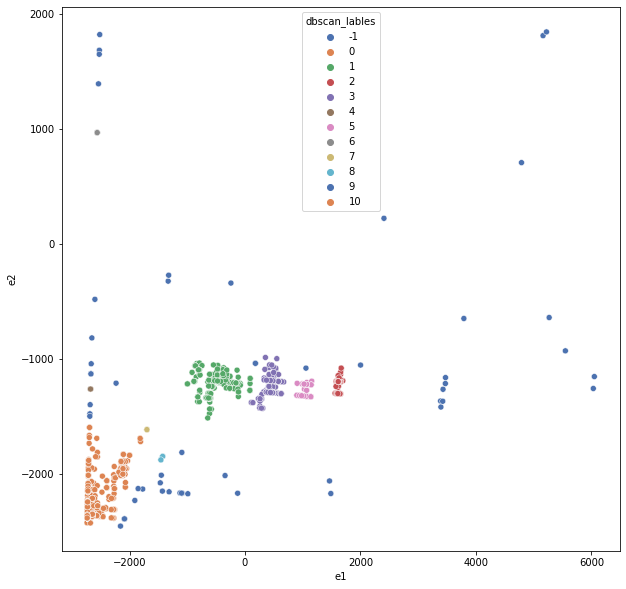

In [21]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=sample_from_good_table,x='e1', y='e2', hue='dbscan_lables', palette="deep")

In [22]:
anomaly_column = []
for item in sample_from_good_table['dbscan_lables'].values:
  if item == -1:
    anomaly_column.append('anomaly')
  else:
    anomaly_column.append('good')

In [23]:
sample_from_good_table['anomaly_column'] = anomaly_column

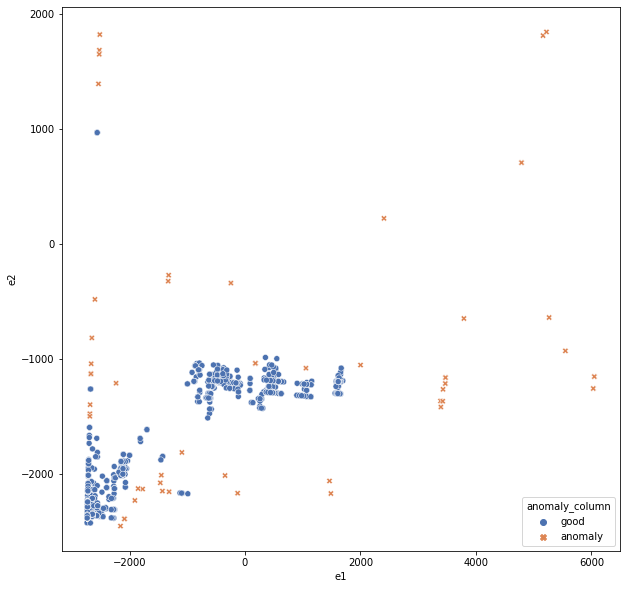

In [24]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=sample_from_good_table,x='e1', y='e2', hue='anomaly_column', palette="deep", style="anomaly_column")

In [27]:
x_pairplot = sample_3000.drop(['label'], axis=1).values

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
low_space_pairplot = pca.fit_transform(x_pairplot)
low_space_table_pairplot = pd.DataFrame(low_space_pairplot, columns=['e1', 'e2', 'e3', 'e4', 'e5', 'e6'])
low_space_table_pairplot['target'] = sample_3000['label'].values
low_space_table_pairplot.head(1)

,e1,e2,e3,e4,e5,e6,target
0,-123.204225,-60.408818,16.317724,-2.294467,-0.124217,0.525557,Benign


In [31]:
low_space_table_pairplot.shape

(3000, 7)

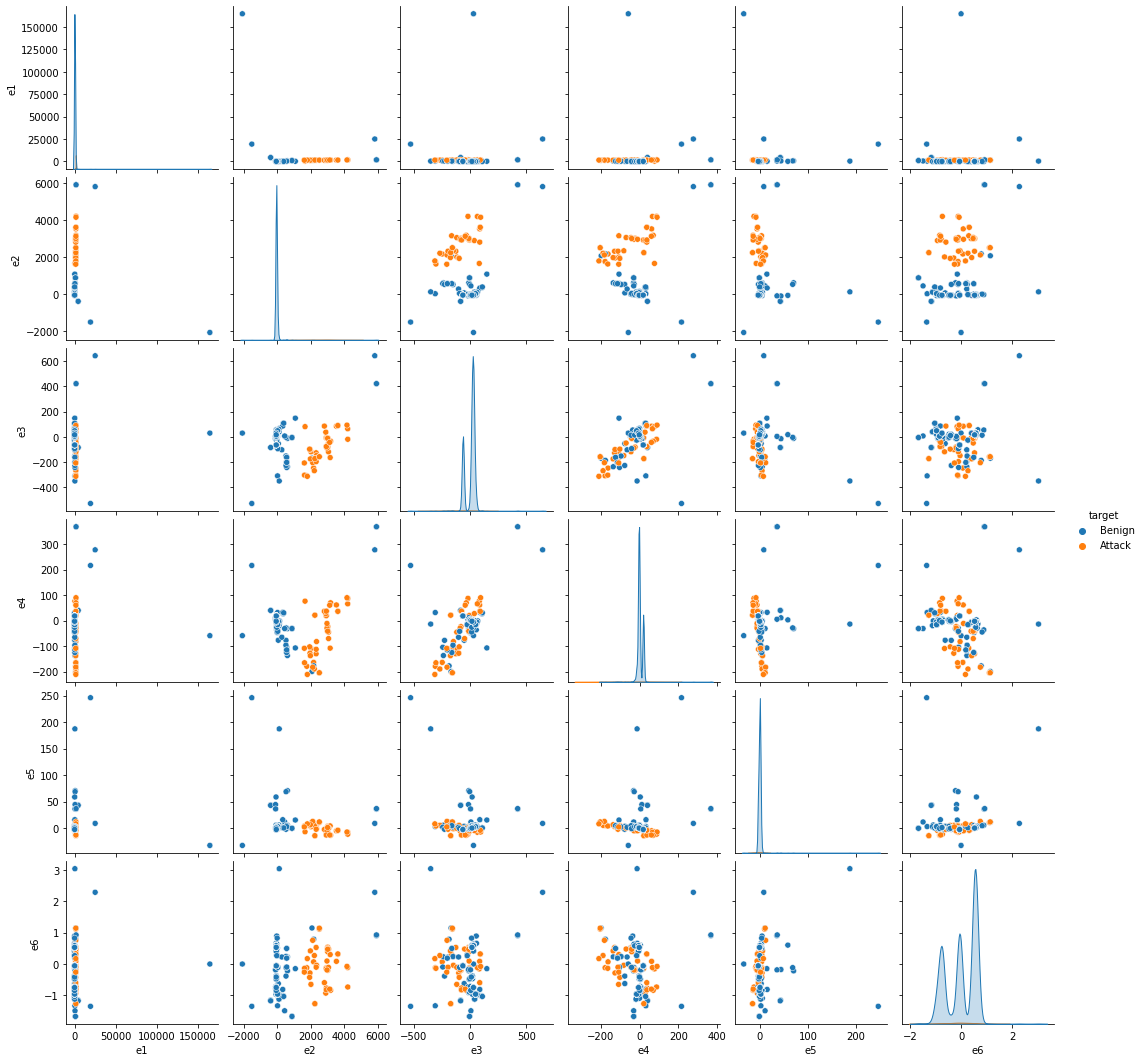

In [32]:
sns.pairplot(low_space_table_pairplot, hue="target")